In [1]:
import galois
from py_ecc.bls12_381 import curve_order
import os
import matplotlib.pyplot as plt
import merkle_tree
from time import time
import numpy as np

from kzg import TrustedEntity, KZGProver, KZGVerifier
from verkle_tree import LeafNode, VerkleTreeNode, VerkleTreeVerifier, build_mock_tree, build_path

Generacija Galoisovega polja - to lahko traja nekaj minut.

In [2]:
GF = galois.GF(curve_order)
print("p:", curve_order)

p: 52435875175126190479447740508185965837690552500527637822603658699938581184513


# Polinomska zaveza KZG

Polinomska zaveza KZG nam omogoča, da se zavežemo polinomu, ki ga podamo kot seznam točk, za katere želimo, da jih polinom obišče.

In [3]:
SRS_degree = 20
kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)
kzg_verifier = KZGVerifier(GF, curve_order, SRS_degree, kzg_prover.SRS_1, kzg_prover.SRS_2)

arr = [(0, 10), (1, 20), (2, 36), (3, 50), (4, 90), (5, 44), (6, 66)]
print("Array: ", arr)
polynomial = kzg_prover.arr_to_poly(arr)
print("Polynomial: ", polynomial)
commitment = kzg_prover.commit_poly(polynomial)
print("Commitment: ", commitment)

print("\nBATCH PROOF")
points = [(0, 10), (1, 20), (5, 44)]
proof = kzg_prover.generate_batch_proof(polynomial, points)
print("Batch proof: ", proof)
kzg_verifier.verify_batch_proof(commitment, points, proof)
print("Batch proof is valid")

print("\nONE POINT PROOF")
point = (3, 50)
one_point_proof = kzg_prover.generate_one_point_proof(polynomial, point)
print("One point proof: ", one_point_proof)
kzg_verifier.verify_one_point_proof(commitment, point, one_point_proof, kzg_verifier.SRS_2)
print("One point proof is valid")

Array:  [(0, 10), (1, 20), (2, 36), (3, 50), (4, 90), (5, 44), (6, 66)]
Polynomial:  31024559478616329367006579800676696453966910229478852378373831397463660534171x^6 + 20537384443591091271117031699039503286428799729373324813853099657475944297254x^5 + 6554484396890773809930967563523245729711319062565954727825457337492322648149x^4 + 28402765719860019843034192775267398162082382604452470487243648462466731474701x^3 + 14856831299619087302510193143986023654012323208482830716404369964982598002597x^2 + 3495725011675079365296516033879064389179370166701842521506910579995905412164x + 10
Commitment:  (1168535217958616408011924054286670528379232475777117838410358213710289685884615400455212648676545523147048180009468, 30998535702551371943538710532020952524812367776380068585649757702986711572101390248618602974615663743564537035155)

BATCH PROOF
Batch proof:  (1992511237310616924354602507792248784488946093613328198471523952242787580717442878272018999094741279083873205417921, 302981928309778863173921115

# Verklovo drevo

Verklovo drevo je kriptografska podatkovna struktura, ki nam omogoča, da dokažemo, da element pripada vnaprej določeni množici.

In [4]:
l1 = [10, 20, 31, 40, 51, 60, 70, 80, 90, 100]
l2 = [30, 40, 50, 60, 70, 81, 90, 100, 110, 120]
l3 = [31, 41, 51, 61, 71, 85, 91, 101, 111, 122]
l4 = [35, 42, 56, 4431, 12171, 2385, 9145, 1012, 28111, 232322]
n1 = VerkleTreeNode(curve_order, list(map(LeafNode, l1)), kzg_prover)
n2 = VerkleTreeNode(curve_order, list(map(LeafNode, l2)), kzg_prover)
n3 = VerkleTreeNode(curve_order, list(map(LeafNode, l3)), kzg_prover)
n4 = VerkleTreeNode(curve_order, list(map(LeafNode, l4)), kzg_prover)
root = VerkleTreeNode(curve_order, [n1, n2, n3, n4], kzg_prover)

print("VERKLE TREE")
print("Number of elements: ", len(root))
print("Root Commitment: ", root.commitment)
path = {0: [(1, 20), (2, 31), (3, 40)], 1: [(1, 40), (2, 50), (3, 60)]}
print("Path", path)
proof = root.generate_proof(path)
print("Proof", proof)

verifier = VerkleTreeVerifier(root.commitment, kzg_verifier)
verifier.validate_proof(path, proof)
print("Proof is valid")

VERKLE TREE
Number of elements:  40
Root Commitment:  (3488183654021699442670325447836088877190491642997412258181558424025812137664975991339665015598951243704414897703120, 257315208906110207768702081827008851194820913312662461211309406829710407111577686682293974244051151394657161112183)
Path {0: [(1, 20), (2, 31), (3, 40)], 1: [(1, 40), (2, 50), (3, 60)]}
Proof {-1: Proof(commitment=(3488183654021699442670325447836088877190491642997412258181558424025812137664975991339665015598951243704414897703120, 257315208906110207768702081827008851194820913312662461211309406829710407111577686682293974244051151394657161112183), proof=(156384119639805105834936127472175083554291940097198053723971304236643226093980866499866424688126199073248876171398, 1609205245088097696908269243369968661623927579208806011518471288138237814761028741242560413585902913670017277464147)), 0: Proof(commitment=(2476649025010882715060410000377503691436516034770922459723454223270674537860112609163532070864843795639393411356422,

In [5]:
SRS_degree = 30
kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)
kzg_verifier = KZGVerifier(GF, curve_order, SRS_degree, kzg_prover.SRS_1, kzg_prover.SRS_2)

depth = 4
width = 30
root = build_mock_tree(depth, width, kzg_prover)
verifier = VerkleTreeVerifier(root.commitment, kzg_verifier)
path = build_path(root)
print("Path", path)
proof = root.generate_proof(path)
print("Proof", proof)
print("Proof size in bytes: ", len(str(proof)))
print("Number of elements:", len(root))

verifier.validate_proof(path, proof)

Path {0: {0: [(0, 28185531971705443869070213117860592910377390359252102944810967966237504789776), (1, 33303377117903694844668711774250205627583110492468057409962529526741437998537)]}}
Proof {-1: Proof(commitment=(3883716627937323858714448523827079058843027647086232517664146805464379724722001504036722085160263982253079462365581, 2260206520969168660609274529952515965109760934011031042725701544594691568619783848191198305524478252465584827032403), proof=(971102226294841027750297514299828585242103394229823442870226263813220167968784198558731896289264203896952887996426, 3609515881876818256296137884090923803696525426259435020826903724768140095231669417784821458046844816025388065082034)), 0: {-1: Proof(commitment=(1097754225704388752032515338402389267126572318526057833670946125794021621004509884851781988657508613597615771122296, 1787375161698552660774050088105720862263411039822354964678935022578754382485732330668600593071680990855570891583082), proof=(165887503324548696261816983104594215085741

# Primerjava velikosti dokazov

Depth: 2, width: 10, number of elements: 10, proof size: 492 bytes
Depth: 3, width: 10, number of elements: 100, proof size: 997 bytes
Depth: 4, width: 10, number of elements: 1000, proof size: 1502 bytes
Depth: 5, width: 10, number of elements: 10000, proof size: 2007 bytes
Depth: 6, width: 10, number of elements: 100000, proof size: 2510 bytes
Depth: 2, width: 30, number of elements: 30, proof size: 493 bytes
Depth: 3, width: 30, number of elements: 900, proof size: 995 bytes
Depth: 4, width: 30, number of elements: 27000, proof size: 1499 bytes
Depth: 5, width: 30, number of elements: 810000, proof size: 2006 bytes
Depth: 6, width: 30, number of elements: 24300000, proof size: 2510 bytes
Depth: 2, width: 50, number of elements: 50, proof size: 490 bytes
Depth: 3, width: 50, number of elements: 2500, proof size: 997 bytes
Depth: 4, width: 50, number of elements: 125000, proof size: 1501 bytes
Depth: 5, width: 50, number of elements: 6250000, proof size: 2005 bytes
Depth: 6, width: 50

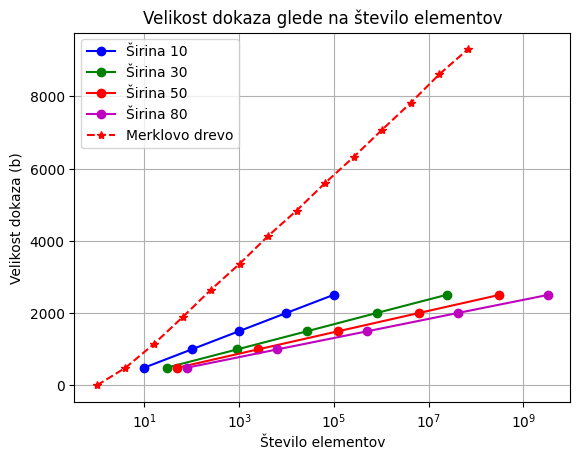

In [6]:
depths = range(2, 7)
widths = [10, 30, 50, 80]
colors = ["b", "g", "r", "m", "y", "k"]

res = {}
res_validation = {}

for i, width in enumerate(widths):
    proof_sizes = []
    num_elements = []
    validation_times = []
    for i in depths:
        SRS_degree = width
        kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
        kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)
        kzg_verifier = KZGVerifier(GF, curve_order, SRS_degree, kzg_prover.SRS_1, kzg_prover.SRS_2)

        root = build_mock_tree(i, width, kzg_prover)
        verifier = VerkleTreeVerifier(root.commitment, kzg_verifier)

        path = build_path(root)
        proof = root.generate_proof(path)
        proof_size = len(str(proof))
        proof_sizes.append(proof_size)
        num_elements.append(len(root))

        start_time = time()
        verifier.validate_proof(path, proof)
        end_time = time()
        validation_time = end_time - start_time
        validation_times.append(validation_time)

        print(f"Depth: {i}, width: {width}, number of elements: {len(root)}, proof size: {proof_size} bytes")
    
    res[width] = (proof_sizes, num_elements)
    res_validation[width] = (validation_times, num_elements)

    
for i, (width, (proof_sizes, num_elements)) in enumerate(res.items()):
    plt.plot(num_elements, proof_sizes, marker="o", color=colors[i % len(colors)], label=f"Širina {width}")

# Merkle tree
merkle_depths = range(1, 28, 2)
num_elements_merkle = []
proof_sizes_merkle = []
for i in merkle_depths:
    
    tree = merkle_tree.build_tree(i)
    proof = tree.get_proof(["left"] * (i - 1))
    print("Proof length: ", len(proof))

    proof_size = len(str(proof))

    num_elements_merkle.append(len(tree))
    proof_sizes_merkle.append(proof_size)

plt.plot(num_elements_merkle, proof_sizes_merkle, marker="*", color="red", label=f"Merklovo drevo", linestyle="--")


plt.xlabel("Število elementov")
plt.ylabel("Velikost dokaza (b)")
plt.xscale("log")
plt.title("Velikost dokaza glede na število elementov")
plt.legend()
plt.grid(True)

output_path = os.path.join("figures", "proof_size_plot.pdf")
plt.savefig(output_path, format="pdf")

plt.show()

# Primerjava časa preverjanja dokaza Verklovega drevesa

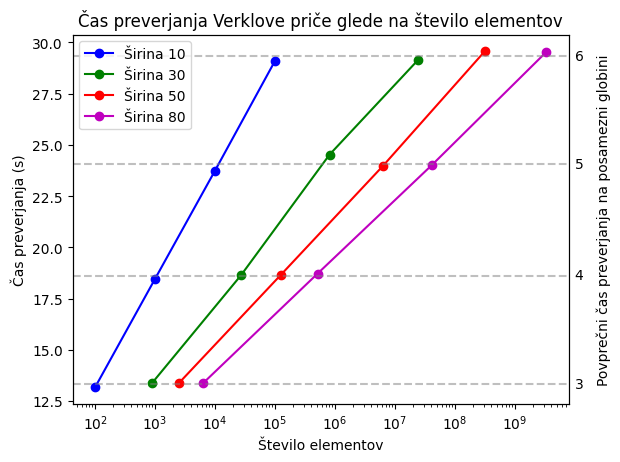

In [7]:
fig, ax = plt.subplots()

for i, (width, (validation_times, num_elements)) in enumerate(res_validation.items()):
    ax.plot(num_elements[1:], validation_times[1:], marker="o", color=colors[i % len(colors)], label=f"Širina {width}")

for d in range(1, len(list(res_validation.values())[0][0])):
    avg_validation_time = np.mean([validation_times[d] for validation_times, _ in res_validation.values()])

    ax.axhline(y=avg_validation_time, color="grey", linestyle="--", alpha=0.5)
    ax.text(max(num_elements) * 3, avg_validation_time, f"{d+2}", verticalalignment="center")

ax.set_xlabel("Število elementov")
ax.set_ylabel("Čas preverjanja (s)")
ax.set_xscale("log")
ax.set_title("Čas preverjanja Verklove priče glede na število elementov")
ax.legend(loc="upper left")
ax.grid(False)

ax2 = ax.twinx()
ax2.set_ylabel("Povprečni čas preverjanja na posamezni globini", color="black", labelpad=20)
ax2.set_yticks([])

output_path = os.path.join("figures", "validation_time_plot.pdf")
plt.savefig(output_path, format="pdf")
plt.show()